# Government spending in the Ramsey model

The first cell just imports packages, defines useful functions and sets parameter values.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Production function
def f(k,α):
    out = k**α
    return out

## Derivative of prod fctn
def fp(k,α):
    out = α * k**(α-1)
    return out

## Utility function
def u(c,σ):
    out = (c**(1-σ)-1)/(1-σ)
    return out

α = 1/3
σ = 1.0001
δ = 0.1
β = 0.96

kmax = 10
knum = 100

## Government spending
g = 0.3


3.6092470063405626


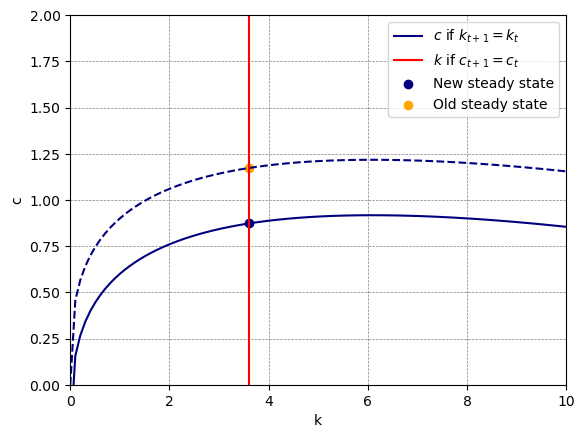

1.1730052770606838
0.14166666666666675


In [3]:
## How does the equilibrium in the Ramsey model change when the government taxes lump sum and spends the proceeds wastefully?

## Laws of motion
# u'(c_t) = β ( 1+r_t+1-δ ) u'(c_t+1)
# k_t+1 = (1-δ)k_t + f(k_t) - c_t 

## k if c is constant
# 1 = β ( 1+f'(k)-δ ) -->
k_star = ((1/β-1+ δ)/α)**(1/(α-1))
print(k_star)

## c if k is constant
#c =  f(k)-δk 
kvec = np.linspace(0,kmax,knum)
c_star = f(kvec,α) - δ*kvec 
c_starstar = f(k_star,α) - δ*k_star


cg_star = f(kvec,α) - δ*kvec -g
cg_starstar = f(k_star,α) - δ*k_star -g

plt.plot(kvec, c_star, color = 'navy', linestyle = 'dashed')
plt.plot(kvec, cg_star, label=r'$c$ if $k_{t+1}=k_t$', color = 'navy')
plt.axvline(x=k_star, label = r'$k$ if $c_{t+1}=c_t$', color = 'red')
plt.scatter(k_star,cg_starstar, label = r'New steady state', color = 'navy')
plt.scatter(k_star,c_starstar, label = r'Old steady state', color = 'orange')
plt.xlabel('k')
plt.ylabel('c')
plt.ylim(0,2)
plt.xlim(0,10)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.savefig('ramsey_g.pdf')        
plt.show()
print(c_starstar)
print(fp(k_star,α))

## Distortionary taxation

The next part of the code estimates a full transition in the Ramsey model for various different tax rates, for various different starting points. The moral of the story is that if capital is taxed, this tax distorts decisions of agents. Hence the equilibrium of the model will change. 

Furthermore, the graphs show that 0 taxation is always preferable. It may seem like a distortionary tax can achieve the Solow-golden-rule level of consumption, but this is not the case, because of the transition towards the steady state. It is less beneficial than any transition to the non-distorted steady state. 

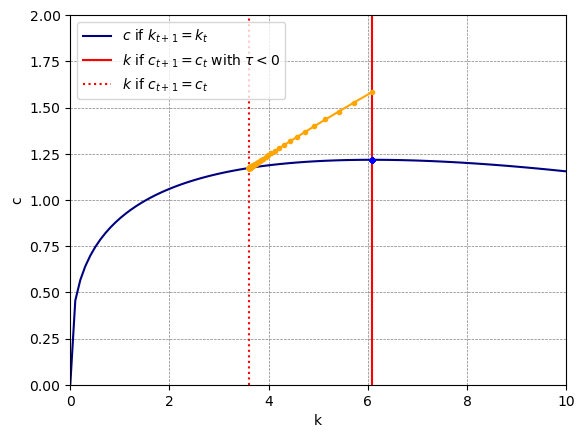

Utility benefit from undistorted transition: 0.9285001781332829


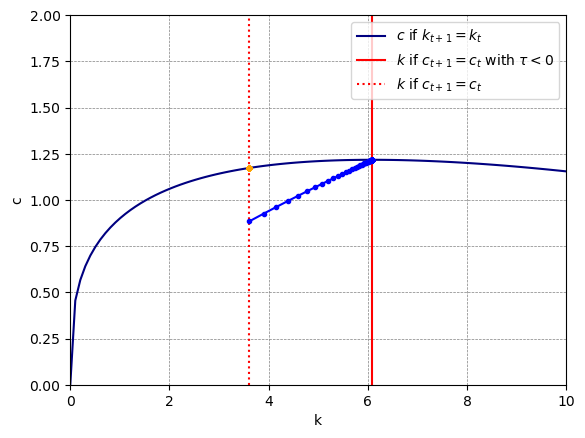

Utility benefit from undistorted transition: 0.9633673536670533


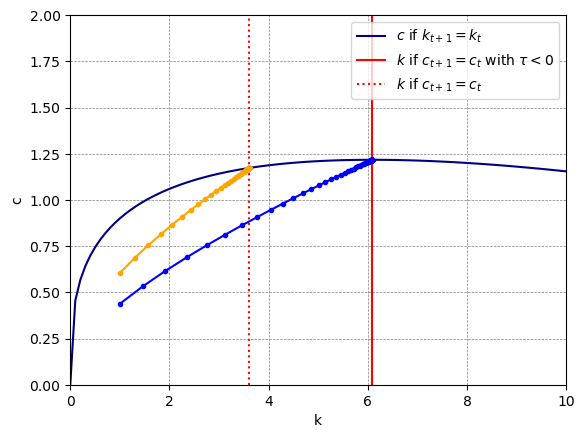

Utility benefit from undistorted transition: 1.0316484665096333


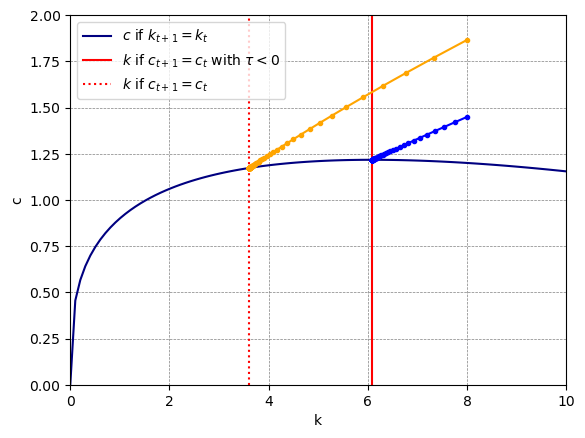

Utility benefit from undistorted transition: 0.9086247158786236


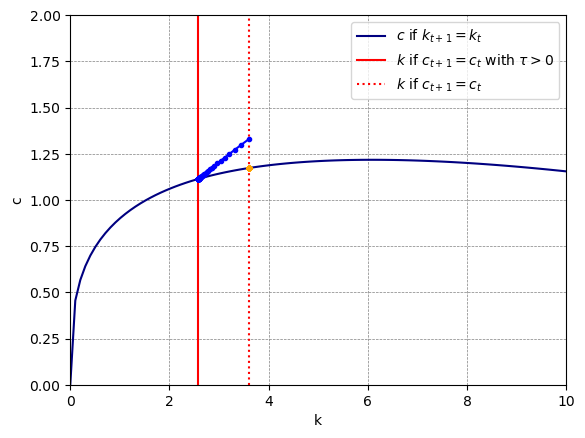

Utility benefit from undistorted transition: 0.25609920138274767


In [6]:
## Distortionary taxation
τ = 0

## Function that models the transition 
def transition(k0,c0,δ,τ,num,maxk,maxc):
    cvec = np.zeros(num)
    kvec = np.zeros(num)
    
    cvec[0] = c0
    kvec[0] = k0
    for i in range(num-1):
        kk = kvec[i]
        cc = cvec[i]
        kvec[i+1] = (1-δ)*kk + f(kk,α) - cc

        cvec[i+1] = ( cc**(-σ) / (β*(1+(1-τ)*fp(kvec[i+1],α)-δ)) ) ** (-1/σ)
        if kvec[i+1]>maxk:
            break
        if cvec[i+1]>maxc:
            break
    ## Drop points outside the allowed area
    cvec = cvec[cvec>0]
    kvec = kvec[kvec>0]
    return cvec, kvec

def bisection(k0,kstar,cstar,δ,τ,tol):

    cond = 10
    ## Initial guess
    if k0 < kstar:
        clow = 0
        chigh = f(k0,α) - δ*k0
    else:
        clow = f(k0,α) - δ*k0
        chigh  = f(k0,α) - δ*k0 + k0
   
    ## Bisection code
    while np.sqrt((clow-chigh)**2)>tol:
        cguess = (clow+chigh)/2
        cc = cguess
        kk = k0
        #print(np.sqrt((clow-chigh)**2))
        freason = interation_bisection(kk,cc,cstar,kstar,k0,δ,τ,tol)
        if freason == 1:
            print('solved')
            return cguess
        if freason == 2:
            chigh = cguess    #update chigh
            
        if freason == 3:
            clow = cguess     #update clow
            
    return cguess

def interation_bisection(kk,cc,cstar,kstar,k0,δ,τ,tol):
    cond = 10
    cguess = cc
    while cond>tol:
        ## Iterate forwards once

        k1 = (1-δ)*kk + f(kk,α) - cc
        c1 = ( cc**(-σ) / (β*(1+(1-τ)*fp(k1,α)-δ)) ) ** (-1/σ)
        
        #The optimal c given the new value for k
        ckstar = f(k1,α) - δ*k1
        ## Test optimality
        cond = np.sqrt((cstar-c1 )**2 + (kstar-k1)**2)
        #print(cond)

        ## if k0<kstar, c0 must always be below steady state
        if k0 < kstar:
            if ((c1 < ckstar) & (k1<kstar)):
                ## Update the values
                cc = c1
                kk = k1
                freason = 1
                continue
            elif  ((c1 > ckstar) & (k1<kstar)):
                ## We're exploding to the top left --> initial guess too high
                freason = 2 #update chigh
                break
            elif  ((c1 < ckstar) & (k1>kstar)):
                ## We're exploding to the bottom right --> initial guess too low
                freason = 3 #update clow
                break
        ## if k0>kstar, c0 must always be above steady state
        if k0 > kstar:
            if ((c1 > ckstar) & (k1>kstar)):
                ## Update the values
                cc = c1
                kk = k1
                freason = 1 #no fail
                continue
            elif  ((c1 < ckstar) & (k1>kstar)):
                ## We're exploding to the bottom right --> initial guess too low
                freason = 3 #update clow
                break
            elif  ((c1 > ckstar) & (k1<kstar)):
                ## We're exploding to the top left --> initial guess too high
                freason = 2 #update chigh
                break 
    
    return freason

## This function calculates the total utility of each transition path
def transu(TT,β,σ,ctrans,ctranstax):
    timevec = np.linspace(0,TT-1,TT)
    betavec = β**timevec
    ubl = betavec * u(ctrans,σ)
    utax = betavec * u(ctranstax,σ)
    return (np.sum(ubl)-np.sum(utax))


####################################################################
## Start at the optimal c level
τ = (1-1/β)/δ
k_star_tax = ((1/β-1+ δ)/(α*(1-τ)))**(1/(α-1))
k0start = k_star_tax-.0001
k_star_tax = ((1/β-1+ δ)/(α*(1-τ)))**(1/(α-1))
c_startax = f(k_star_tax,α) - δ*k_star_tax

asdftax = bisection(k0start,k_star_tax,c_startax,δ,τ,10**-15)
asdf = bisection(k0start,k_star,c_starstar,δ,0,10**-15)


plt.plot(kvec, c_star, label=r'$c$ if $k_{t+1}=k_t$', color = 'navy')
plt.axvline(x=k_star_tax, label = r'$k$ if $c_{t+1}=c_t$ with $\tau<0$', color = 'red')
plt.axvline(x=k_star, label = r'$k$ if $c_{t+1}=c_t$', color = 'red', linestyle = 'dotted')
plt.xlabel('k')
plt.ylabel('c')
plt.ylim(0,2)
plt.xlim(0,10)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend()

## The navy-colored lines are always transition paths towards the distorted steady state
ctranstax,ktranstax = transition(k0start, asdftax,δ,τ,100,10,10)
plt.plot(ktranstax,ctranstax, color = 'blue', marker = '.', label ='Convergence path')

ctrans,ktrans = transition(k0start, asdf,δ,0,100,10,10)
## The orange  lines are always transition paths towards the undistorted steady state
ctranstax,ktranstax = transition(k0start, asdftax,δ,τ,100,10,10)
plt.plot(ktrans,ctrans, color = 'orange', marker = '.', label ='Convergence path')
plt.savefig('negtax_optk.pdf')
plt.show()
uT = transu(100,β,σ,ctrans,ctranstax)
print("Utility benefit from undistorted transition:", uT)
####################################################################
## Start at the bl c level
k0start = k_star-.0001
τ = (1-1/β)/δ
k_star_tax = ((1/β-1+ δ)/(α*(1-τ)))**(1/(α-1))
c_startax = f(k_star_tax,α) - δ*k_star_tax

asdftax = bisection(k0start,k_star_tax,c_startax,δ,τ,10**-15)
asdf = bisection(k0start,k_star,c_starstar,δ,0,10**-15)

plt.plot(kvec, c_star, label=r'$c$ if $k_{t+1}=k_t$', color = 'navy')
plt.axvline(x=k_star_tax, label = r'$k$ if $c_{t+1}=c_t$ with $\tau<0$', color = 'red')
plt.axvline(x=k_star, label = r'$k$ if $c_{t+1}=c_t$', color = 'red', linestyle = 'dotted')
plt.xlabel('k')
plt.ylabel('c')
plt.ylim(0,2)
plt.xlim(0,10)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend()

ctranstax,ktranstax = transition(k0start, asdftax,δ,τ,100,10,10)
plt.plot(ktranstax,ctranstax, color = 'blue', marker = '.', label ='Convergence path')

ctrans,ktrans = transition(k0start, asdf,δ,0,100,10,10)
plt.plot(ktrans,ctrans, color = 'orange', marker = '.', label ='Convergence path')
plt.savefig('negtax_blk.pdf')
plt.show()
uT = transu(100,β,σ,ctrans,ctranstax)
print("Utility benefit from undistorted transition:", uT)
####################################################################
## Start at some low level of capital
k0start = 1 #k_star-.0001
τ = (1-1/β)/δ
k_star_tax = ((1/β-1+ δ)/(α*(1-τ)))**(1/(α-1))
c_startax = f(k_star_tax,α) - δ*k_star_tax

asdftax = bisection(k0start,k_star_tax,c_startax,δ,τ,10**-15)
asdf = bisection(k0start,k_star,c_starstar,δ,0,10**-15)

plt.plot(kvec, c_star, label=r'$c$ if $k_{t+1}=k_t$', color = 'navy')
plt.axvline(x=k_star_tax, label = r'$k$ if $c_{t+1}=c_t$ with $\tau<0$', color = 'red')
plt.axvline(x=k_star, label = r'$k$ if $c_{t+1}=c_t$', color = 'red', linestyle = 'dotted')
plt.xlabel('k')
plt.ylabel('c')
plt.ylim(0,2)
plt.xlim(0,10)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend()

ctranstax,ktranstax = transition(k0start, asdftax,δ,τ,100,10,10)
plt.plot(ktranstax,ctranstax, color = 'blue', marker = '.', label ='Convergence path')

ctrans,ktrans = transition(k0start, asdf,δ,0,100,10,10)
plt.plot(ktrans,ctrans, color = 'orange', marker = '.', label ='Convergence path')
plt.savefig('negtax_lowk.pdf')
plt.show()
uT = transu(100,β,σ,ctrans,ctranstax)
print("Utility benefit from undistorted transition:", uT)
####################################################################
## Start at some high level of capital
k0start = 8 #k_star-.0001
τ = (1-1/β)/δ
k_star_tax = ((1/β-1+ δ)/(α*(1-τ)))**(1/(α-1))
c_startax = f(k_star_tax,α) - δ*k_star_tax

asdftax = bisection(k0start,k_star_tax,c_startax,δ,τ,10**-15)
asdf = bisection(k0start,k_star,c_starstar,δ,0,10**-15)

plt.plot(kvec, c_star, label=r'$c$ if $k_{t+1}=k_t$', color = 'navy')
plt.axvline(x=k_star_tax, label = r'$k$ if $c_{t+1}=c_t$ with $\tau<0$', color = 'red')
plt.axvline(x=k_star, label = r'$k$ if $c_{t+1}=c_t$', color = 'red', linestyle = 'dotted')
plt.xlabel('k')
plt.ylabel('c')
plt.ylim(0,2)
plt.xlim(0,10)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend()

ctranstax,ktranstax = transition(k0start, asdftax,δ,τ,100,10,10)
plt.plot(ktranstax,ctranstax, color = 'blue', marker = '.', label ='Convergence path')

ctrans,ktrans = transition(k0start, asdf,δ,0,100,10,10)
plt.plot(ktrans,ctrans, color = 'orange', marker = '.', label ='Convergence path')
plt.savefig('negtax_highk.pdf')
plt.show()
uT = transu(100,β,σ,ctrans,ctranstax)
print("Utility benefit from undistorted transition:", uT)

####################################################################
## Start at some high level of capital
k0start = k_star-.0001
τ = 0.2
k_star_tax = ((1/β-1+ δ)/(α*(1-τ)))**(1/(α-1))
c_startax = f(k_star_tax,α) - δ*k_star_tax

asdftax = bisection(k0start,k_star_tax,c_startax,δ,τ,10**-15)
asdf = bisection(k0start,k_star,c_starstar,δ,0,10**-15)

plt.plot(kvec, c_star, label=r'$c$ if $k_{t+1}=k_t$', color = 'navy')
plt.axvline(x=k_star_tax, label = r'$k$ if $c_{t+1}=c_t$ with $\tau>0$', color = 'red')
plt.axvline(x=k_star, label = r'$k$ if $c_{t+1}=c_t$', color = 'red', linestyle = 'dotted')
plt.xlabel('k')
plt.ylabel('c')
plt.ylim(0,2)
plt.xlim(0,10)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend()
ctranstax,ktranstax = transition(k0start, asdftax,δ,τ,100,10,10)
plt.plot(ktranstax,ctranstax, color = 'blue', marker = '.', label ='Convergence path')

ctrans,ktrans = transition(k0start, asdf,δ,0,100,10,10)
plt.plot(ktrans,ctrans, color = 'orange', marker = '.', label ='Convergence path')

plt.savefig('postax_notrans.pdf')
plt.show()
uT = transu(100,β,σ,ctrans,ctranstax)
print("Utility benefit from undistorted transition:", uT)
